In [1]:
# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer

#Librairies
import time
import torch
import random

#Raccourcis utilisé
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.utils.data as data_utils
import pandas as pd

In [2]:
def to_class(y_):
    res = np.zeros((len(y_), 11), dtype='q')
    for i in range(len(y_)):
        res[i][int(y_[i])] = 1
    return res
def minimum(liste):
    mini = liste[0]
    for i in liste:
        if i <= mini:
            mini = i
    return mini
def maximum(liste):
    maxi = liste[0]
    for i in liste:
        if i >= maxi:
            maxi = i
    return maxi
# Normalisation
sc = StandardScaler()

In [6]:
dfX = pd.read_csv('Molecular Dataset Dream 2.csv',sep=';')
dfY = pd.read_csv('Senteur Dataset Dream 2.csv',sep=';')

In [7]:
df = dfX.merge(dfY)

In [8]:
list_label = ['INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

#Pour les barplot
list_label_bar = ['INTENSITY', 'VALENCE', 'BAKERY', 'SWEET',
       'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID',
       'WARM', 'MUSKY', 'SWEATY', 'AMMONIA', 'DECAYED', 'WOOD',
       'GRASS', 'FLOWER', 'CHEMICAL']

Dico_labels = {}
for i in range (21):
    Dico_labels[i] = list_label[i]

# Le modele

In [9]:
class MyNetwork(nn.Module):

    def __init__(self):
        super(MyNetwork, self).__init__()
        
        ## Activation layer
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(in_features = 3081, out_features = 2400)
        self.fc2 = nn.Linear(2400, 1200)  
        self.fc3 = nn.Linear(1200, 600)
        self.output = nn.Linear(600, 11)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):

    ## First full connection
        x = self.fc1(x)
        x = self.relu(x)
    
    ## Second full connection
        x = self.fc2(x)
        x = self.relu(x)
 
    ## Third full connection
        x = self.fc3(x)
        x = self.relu(x)
        
    ## Output layer
        x = self.output(x)
        y = self.softmax(x)
        
        return y

# Boucle d'Apprentissage pour les Labels

In [10]:
df

,Unnamed: 0,CID,complexity from pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,...,ACID,WARM,MUSKY,SWEATY,AMMONIA/URINOUS,DECAYED,WOOD,GRASS,FLOWER,CHEMICAL
0,0,126,93.1,122.13,8.142,10.010,15.305,10.193,16.664,0.667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
1,1,126,93.1,122.13,8.142,10.010,15.305,10.193,16.664,0.667,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
2,2,176,31.0,60.06,7.508,4.483,8.422,4.432,9.249,0.560,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3,3,176,31.0,60.06,7.508,4.483,8.422,4.432,9.249,0.560,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,177,10.3,44.06,6.294,3.768,7.095,3.977,8.040,0.538,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,801,6429333,152.0,146.20,6.962,13.349,20.745,14.261,23.285,0.636,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
802,802,6999977,101.0,146.21,6.092,12.832,24.167,13.693,27.535,0.535,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
803,803,6999977,101.0,146.21,6.092,12.832,24.167,13.693,27.535,0.535,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0
804,804,16220109,202.0,182.29,5.880,17.171,30.607,18.762,35.156,0.554,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


In [11]:
Label_acc_Train_15, Label_acc_Train_30 = [],[]
Label_acc_Val_15, Label_acc_Val_30 = [],[]
Label_loss_Train_15, Label_loss_Train_30 = [],[]
Label_loss_Val_15, Label_loss_Val_30 = [],[]

for j in range(len(list_label)):
    print('Prédiction du label:',Dico_labels[j])
    dfY = df[[Dico_labels[j]]]
    dfX = df
    dfX = dfX.drop(list_label,axis=1)
    dfX = dfX.drop('Unnamed: 0',axis=1)
    dfX = dfX.drop('CID',axis=1)
    dataX = np.float32(dfX.values)
    dataY = np.longlong(dfY.values)
    dataY = to_class(dataY)
    dataX = sc.fit_transform(dataX)
    
    DATA_Train, DATA_Test, TARGET_Train, TARGET_Test = train_test_split(dataX, dataY ,test_size=0.05)
    
    Batch=30
    X_train_tensor = torch.from_numpy(DATA_Train)
    Y_train_tensor = torch.from_numpy(TARGET_Train)
    X_test_tensor = torch.from_numpy(DATA_Test)
    Y_test_tensor = torch.from_numpy(TARGET_Test)

    train = data_utils.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = data_utils.DataLoader(train, batch_size=Batch, shuffle=True)
    test = data_utils.TensorDataset(X_test_tensor, Y_test_tensor)
    test_loader = data_utils.DataLoader(test, batch_size=Batch, shuffle=True)
    
    net = MyNetwork()
    net = net.cuda()
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    N_EPOCHS = 30 
    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
    start_time = time.time()
    
    for e in range(N_EPOCHS):       
        ### boucle d'entraineement
        running_loss = 0
        running_accuracy = 0
        running_acc=0
        start_epoch_time=time.time()
        
        ## Le réseau est mis en mode "entrainement"
        net.train()
        for i, batch in enumerate(train_loader):
            
            # Obtenir batch du dataloader
            x = batch[0]
            labels = batch[1]
            # déplacer le batch sur le GPU
            x = x.cuda()
            labels = labels.cuda()
            # Calcul de l'output et les loss
            output = net(x)
            y = output
            loss = criterion(y, torch.max(labels, 1)[1])
            # Réinitialisation du gradients
            optimizer.zero_grad()
            # Calculs du gradients
            loss.backward()
            # Appliquecation d'une étape d'optimisation de l'algorithme de descente pour mettre à jour les poids
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
                running_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()
                
        epoch_loss.append(running_loss/len(train))
        epoch_acc.append(running_accuracy/len(train))
         
        ### Boucle de valisation
        ## Le réseau est mis en mode validation
        net.eval()
        running_val_loss = 0
        running_val_accuracy = 0                
        for i, batch in enumerate(test_loader):
            with torch.no_grad():
                x = batch[0]
                labels = batch[1]
                x = x.cuda()
                labels = labels.cuda()
                output = net(x)
                y = output
            
                loss = criterion(y, torch.max(labels, 1)[1])
                running_val_loss += loss.item()
                running_val_accuracy += (y.max(1)[1] == torch.max(labels, 1)[1]).sum().item()

            epoch_val_loss.append(running_val_loss/len(test))
            epoch_val_acc.append(running_val_accuracy/len(test))
        if e == 14 :
            Label_acc_Train_15.append(maximum(epoch_acc))
            Label_acc_Val_15.append(maximum(epoch_val_acc))
            Label_loss_Train_15.append(minimum(epoch_loss))
            Label_loss_Val_15.append(minimum(epoch_val_loss))

        if e == 29 :
            Label_acc_Train_30.append(maximum(epoch_acc))
            Label_acc_Val_30.append(maximum(epoch_val_acc))
            Label_loss_Train_30.append(minimum(epoch_loss))
            Label_loss_Val_30.append(minimum(epoch_val_loss))
    interval = time.time() - start_time
    print ('Best accuracy d entrainement',maximum(epoch_acc))
    print ('Temps total en secondes:', interval)
    del net
    print(  )

Prédiction du label: INTENSITY/STRENGTH
Best accuracy d entrainement 0.807843137254902
Temps total en secondes: 6.582735300064087

Prédiction du label: VALENCE/PLEASANTNESS
Best accuracy d entrainement 0.7529411764705882
Temps total en secondes: 6.245676517486572

Prédiction du label: BAKERY
Best accuracy d entrainement 0.9032679738562092
Temps total en secondes: 6.342891216278076

Prédiction du label: SWEET
Best accuracy d entrainement 0.7777777777777778
Temps total en secondes: 6.198466539382935

Prédiction du label: FRUIT
Best accuracy d entrainement 0.8679738562091504
Temps total en secondes: 6.193755149841309

Prédiction du label: FISH
Best accuracy d entrainement 0.865359477124183
Temps total en secondes: 6.231496572494507

Prédiction du label: GARLIC
Best accuracy d entrainement 0.9529411764705882
Temps total en secondes: 6.382957220077515

Prédiction du label: SPICES
Best accuracy d entrainement 0.9150326797385621
Temps total en secondes: 6.388363599777222

Prédiction du label:

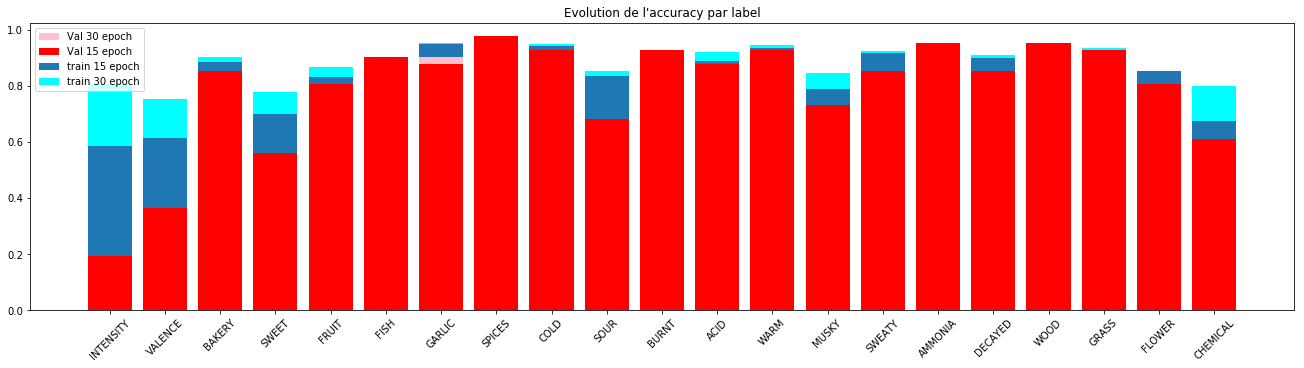

In [12]:
plt.subplots(1,figsize=(18,5),constrained_layout=True)
d = plt.bar(list_label_bar,Label_acc_Train_30,color=['cyan'])
c = plt.bar(list_label_bar,Label_acc_Train_15)
a = plt.bar(list_label_bar,Label_acc_Val_30,color=['pink'])
b = plt.bar(list_label_bar,Label_acc_Val_15,color=['red'])
plt.title("Evolution de l'accuracy par label")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

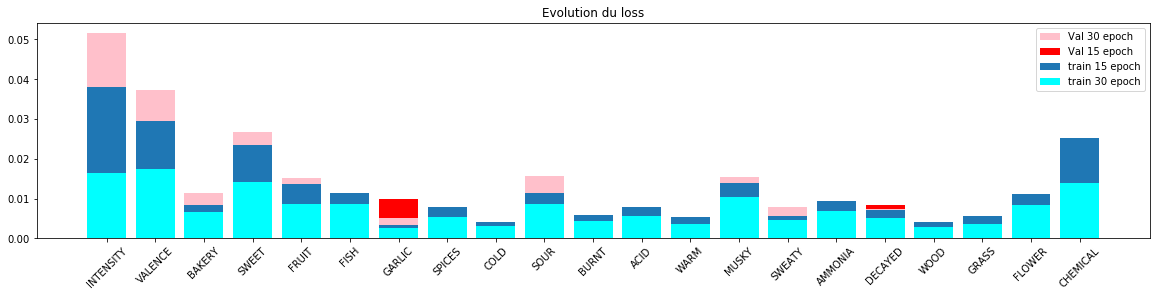

In [14]:
plt.subplots(1,figsize=(16,4),constrained_layout=True)
b = plt.bar(list_label_bar,Label_loss_Val_15,color=['red'])
a = plt.bar(list_label_bar,Label_loss_Val_30,color=['pink'])
c = plt.bar(list_label_bar,Label_loss_Train_15)
d = plt.bar(list_label_bar,Label_loss_Train_30,color=['cyan'])
plt.title("Evolution du loss")
plt.legend((a,b,c,d),('Val 30 epoch','Val 15 epoch','train 15 epoch','train 30 epoch'))
plt.xticks(rotation=45)